In [1]:
import os
import random
from glob import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio

# For Mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)
print("PyTorch version:", torch.__version__)
print("TorchAudio version:", torchaudio.__version__)


Using device: cuda
PyTorch version: 2.8.0+cu129
TorchAudio version: 2.8.0+cu129


In [2]:
# Hyperparameters & paths

BASE_DIR = "C:\\Users\\razic\\OneDrive\\Desktop\\Speech processing project\\ROOT"
LIBRISPEECH_ROOT = BASE_DIR 
DEMAND_ROOT      = os.path.join(BASE_DIR, "noise")

# Will use 16 kHz audio
TARGET_SAMPLE_RATE = 16000

# Training / validation / test subsets from LibriSpeech
TRAIN_SUBSET = "train-clean"
VAL_SUBSET   = "dev-clean"
TEST_SUBSET  = "test-clean"

# SNR levels in dB for mixing
TRAIN_SNR_LEVELS = [0, 5, 10, 15, 20]
TEST_SNR_LEVELS  = [0, 5, 10, 15, 20]

# Fixed length (seconds) of audio segments during training
SEGMENT_DURATION = 3.0  # seconds
SEGMENT_SAMPLES = int(TARGET_SAMPLE_RATE * SEGMENT_DURATION)


In [3]:
# Audio utility functions

def load_audio(path, target_sr=TARGET_SAMPLE_RATE):
    """
    Load an audio file and resample to target_sr (mono).
    Returns: torch.Tensor [1, T] and sample_rate
    """

    waveform, sr = torchaudio.load(path, backend="soundfile")
    
    # Convert to mono if needed
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    # Resample if needed
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(sr, target_sr)
        waveform = resampler(waveform)
        sr = target_sr
    return waveform, sr


def rms_energy(x):
    """
    Root-mean-square energy of a 1D torch tensor.
    """
    return torch.sqrt(torch.mean(x ** 2) + 1e-8)


def mix_clean_and_noise(clean, noise, snr_db):
    """
    Mix clean and noise at a desired SNR (in dB).
    clean, noise: torch.Tensor [1, T]
    Returns:
        noisy: clean + scaled_noise
        scaled_noise: noise after scaling (same length as clean)
    """
    # Make noise same length as clean
    if noise.shape[1] < clean.shape[1]:
        # Loop / tile noise
        repeat_factor = int(np.ceil(clean.shape[1] / noise.shape[1]))
        noise = noise.repeat(1, repeat_factor)
    noise = noise[:, :clean.shape[1]]

    # Compute scaling factor for desired SNR
    clean_rms = rms_energy(clean)
    noise_rms = rms_energy(noise)

    desired_noise_rms = clean_rms / (10 ** (snr_db / 20))
    scale = desired_noise_rms / (noise_rms + 1e-8)

    scaled_noise = noise * scale
    noisy = clean + scaled_noise

    return noisy, scaled_noise


def compute_snr_db(clean, noisy):
    """
    Compute SNR (dB) between clean and noisy.
    SNR = 10 * log10( P_signal / P_noise )
    where P_signal = mean(clean^2),
          P_noise  = mean((noisy - clean)^2)
    """
    signal_power = torch.mean(clean ** 2) + 1e-8
    noise_power = torch.mean((noisy - clean) ** 2) + 1e-8
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()


In [4]:
# Collect file lists

def collect_librispeech_files(root, subset):
    """
    Collect all .flac files from a LibriSpeech subset.
    E.g., subset = 'train-clean', 'dev-clean', 'test-clean'
    """
    # Handle the nested structure: subset/subset/speaker_id/...
    subset_dir = os.path.join(root, subset, subset)
    if not os.path.exists(subset_dir):
        # Try without nested structure
        subset_dir = os.path.join(root, subset)
    
    flac_files = glob(os.path.join(subset_dir, "**", "*.flac"), recursive=True)
    flac_files = sorted(flac_files)
    print(f"{subset}: found {len(flac_files)} files in {subset_dir}")
    return flac_files


def collect_demand_noise_files(root):
    """
    Collect all DEMAND noise wav files from subfolders.
    Structure: root/SUBFOLDER/*.wav
    """
    # Get all subfolders
    noise_files = []
    for subfolder in os.listdir(root):
        subfolder_path = os.path.join(root, subfolder)
        if os.path.isdir(subfolder_path):
            pattern = os.path.join(subfolder_path, "*.wav")
            files = glob(pattern)
            noise_files.extend(files)
    
    noise_files = sorted(noise_files)
    print(f"DEMAND: found {len(noise_files)} noise files in {root}")
    return noise_files

train_clean_files = collect_librispeech_files(LIBRISPEECH_ROOT, TRAIN_SUBSET)
val_clean_files   = collect_librispeech_files(LIBRISPEECH_ROOT, VAL_SUBSET)
test_clean_files  = collect_librispeech_files(LIBRISPEECH_ROOT, TEST_SUBSET)

noise_files = collect_demand_noise_files(DEMAND_ROOT)


train-clean: found 28539 files in C:\Users\razic\OneDrive\Desktop\Speech processing project\ROOT\train-clean
dev-clean: found 2703 files in C:\Users\razic\OneDrive\Desktop\Speech processing project\ROOT\dev-clean
test-clean: found 2620 files in C:\Users\razic\OneDrive\Desktop\Speech processing project\ROOT\test-clean
DEMAND: found 272 noise files in C:\Users\razic\OneDrive\Desktop\Speech processing project\ROOT\noise


In [5]:
class SpeechDenoiseDataset(Dataset):
    def __init__(self, clean_files, noise_files, snr_levels, segment_samples=SEGMENT_SAMPLES, mode="train"):
        """
        clean_files: list of paths to LibriSpeech flac files
        noise_files: list of paths to DEMAND wav files
        snr_levels: list of SNR dB values to sample from
        segment_samples: number of samples per segment
        mode: 'train', 'val', or 'test'
        """
        self.clean_files = clean_files
        self.noise_files = noise_files
        self.snr_levels = snr_levels
        self.segment_samples = segment_samples
        self.mode = mode

    def __len__(self):
        return len(self.clean_files)

    def random_segment(self, audio):
        """
        Given audio [1, T], crop a random segment of length segment_samples.
        If shorter, pad with zeros.
        """
        num_samples = audio.shape[1]
        if num_samples <= self.segment_samples:
            pad_amount = self.segment_samples - num_samples
            audio = torch.nn.functional.pad(audio, (0, pad_amount))
            return audio
        else:
            start = random.randint(0, num_samples - self.segment_samples)
            return audio[:, start:start + self.segment_samples]

    def __getitem__(self, idx):
        clean_path = self.clean_files[idx]

        # Random noise file
        noise_path = random.choice(self.noise_files)

        # Load audio
        clean, _ = load_audio(clean_path)
        noise, _ = load_audio(noise_path)

        # Random segment (for both clean and noise)
        clean_seg = self.random_segment(clean)
        noise_seg = self.random_segment(noise)

        # Choose SNR
        snr_db = random.choice(self.snr_levels)

        # Mix
        noisy_seg, _ = mix_clean_and_noise(clean_seg, noise_seg, snr_db)

        return {
            "noisy": noisy_seg.squeeze(0),  # [T]
            "clean": clean_seg.squeeze(0),  # [T]
            "snr_db": snr_db}

In [6]:
# DataLoaders

# FULL TRAINING SETUP 
BATCH_SIZE = 16  # batch size for full dataset to manage memory
NUM_WORKERS = 0 

# Use FULL dataset for production training
train_files_subset = train_clean_files  # 100% of data (~28,539 files)
val_files_subset = val_clean_files      # 100% of data (~2,703 files)
test_files_subset = test_clean_files    # 100% of data (~2,620 files)

train_dataset = SpeechDenoiseDataset(
    clean_files=train_files_subset,
    noise_files=noise_files,
    snr_levels=TRAIN_SNR_LEVELS,
    segment_samples=SEGMENT_SAMPLES,
    mode="train"
)

val_dataset = SpeechDenoiseDataset(
    clean_files=val_files_subset,
    noise_files=noise_files,
    snr_levels=TRAIN_SNR_LEVELS,
    segment_samples=SEGMENT_SAMPLES,
    mode="val"
)

test_dataset = SpeechDenoiseDataset(
    clean_files=test_files_subset,
    noise_files=noise_files,
    snr_levels=TEST_SNR_LEVELS,
    segment_samples=SEGMENT_SAMPLES,
    mode="test"
)

def collate_fn(batch):
    """
    Simple collate: stack tensors along batch dimension.
    Each element in batch is a dict.
    """
    noisy = torch.stack([item["noisy"] for item in batch], dim=0)
    clean = torch.stack([item["clean"] for item in batch], dim=0)
    snr_db = torch.tensor([item["snr_db"] for item in batch], dtype=torch.float32)
    return noisy, clean, snr_db

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False,  # batch_size=1 for easy per-utterance eval
    num_workers=NUM_WORKERS, collate_fn=collate_fn
)

print(f"QUICK TEST MODE: Using {len(train_dataset)} train files (25% of full dataset)")
print(f"Batches per epoch: {len(train_loader)} train, {len(val_loader)} val")
print(f"Estimated time per epoch: ~15-20 minutes for LSTM-DRNN")
print(f"Note: This is for testing only - will use 100% data for final training")
len(train_loader), len(val_loader), len(test_loader)
print(f"Note: This is PRODUCTION training with complete dataset")
print(f"Estimated time per epoch: ~60-75 minutes for LSTM-DRNN on full data")
print(f"FULL TRAINING MODE: Using {len(train_dataset)} train files (100% of dataset)")

QUICK TEST MODE: Using 28539 train files (25% of full dataset)
Batches per epoch: 1784 train, 169 val
Estimated time per epoch: ~15-20 minutes for LSTM-DRNN
Note: This is for testing only - will use 100% data for final training
Note: This is PRODUCTION training with complete dataset
Estimated time per epoch: ~60-75 minutes for LSTM-DRNN on full data
FULL TRAINING MODE: Using 28539 train files (100% of dataset)


In [7]:
# LSTM-DRNN Architecture (from paper: Weninger et al.)

class LSTM_DRNN(nn.Module):
    """
    Bidirectional LSTM-based Deep Recurrent Neural Network for speech enhancement.
    
    Architecture:
    - 3-layer bidirectional LSTM (processes sequences forward AND backward)
    - 512 hidden units per direction (1024 total per layer)
    - Predicts time-frequency masks on magnitude spectrograms
    - Sigmoid output for soft masking (equation 5)
    """
    def __init__(self, input_size=257, hidden_size=512, num_layers=3, bidirectional=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # STFT parameters (for converting waveform to spectrogram)
        self.n_fft = 512
        self.hop_length = 128
        self.win_length = 512
        
        # LSTM layers 
        # When bidirectional=True, LSTM processes sequence both forward and backward
        # Output size will be hidden_size * 2
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.2 if num_layers > 1 else 0.0)
        
        # Output layer to predict mask 
        # Input size is doubled for bidirectional LSTM
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.output_layer = nn.Sequential(
            nn.Linear(lstm_output_size, input_size),
            nn.Sigmoid()  # Mask values between 0 and 1
        )
    
    def forward(self, noisy_waveform, return_mask=False):
        """
        Args:
            noisy_waveform: [batch, time_samples]
            return_mask: If True, return (enhanced_waveform, mask, noisy_magnitude)
        Returns:
            enhanced_waveform: [batch, time_samples]
            OR (enhanced_waveform, mask, noisy_magnitude) if return_mask=True
        """
        batch_size, time_samples = noisy_waveform.shape
        
        # Convert waveform to magnitude spectrogram
        # STFT: [batch, freq_bins, time_frames, 2] (real and imaginary parts)
        noisy_stft = torch.stft(
            noisy_waveform,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=torch.hann_window(self.win_length).to(noisy_waveform.device),
            return_complex=True
        )
        
        # Get magnitude and phase
        noisy_magnitude = torch.abs(noisy_stft)  # [batch, freq_bins, time_frames]
        noisy_phase = torch.angle(noisy_stft)
        
        # Prepare input for LSTM: [batch, time_frames, freq_bins]
        lstm_input = noisy_magnitude.permute(0, 2, 1)
        
        # LSTM forward pass 
        # Bidirectional LSTM processes sequence in both directions
        # Output concatenates forward and backward hidden states
        lstm_output, _ = self.lstm(lstm_input)  # [batch, time_frames, hidden_size*2 for bidirectional]
        
        # Predict mask
        mask = self.output_layer(lstm_output)  # [batch, time_frames, freq_bins]
        
        # Apply mask to magnitude spectrogram
        mask = mask.permute(0, 2, 1)  # [batch, freq_bins, time_frames]
        enhanced_magnitude = mask * noisy_magnitude
        
        # Reconstruct waveform using original phase
        enhanced_stft = enhanced_magnitude * torch.exp(1j * noisy_phase)
        
        # Inverse STFT
        enhanced_waveform = torch.istft(
            enhanced_stft,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=torch.hann_window(self.win_length).to(noisy_waveform.device),
            length=time_samples)
        
        if return_mask:
            return enhanced_waveform, mask, noisy_magnitude
        return enhanced_waveform


# Initialize model (BLSTM-PSA architecture)
lstm_model = LSTM_DRNN(
    input_size=257,  # (n_fft // 2) + 1 = 257 frequency bins
    hidden_size=512,  # 512 units per direction (1024 total when bidirectional)
    num_layers=3,
    bidirectional=True  # Enables BLSTM (processes sequences both directions)
).to(device)

print("="*80)
print("BLSTM-DRNN Model")
print("="*80)
print(lstm_model)
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")
print("\nArchitecture details:")
print(f"- Model type: {'BLSTM (Bidirectional)' if lstm_model.bidirectional else 'Unidirectional LSTM'}")
print(f"- LSTM layers: {lstm_model.num_layers}")
print(f"- Hidden units per direction: {lstm_model.hidden_size}")
print(f"- Total hidden units: {lstm_model.hidden_size * 2 if lstm_model.bidirectional else lstm_model.hidden_size}")
print(f"- Input size (freq bins): {lstm_model.input_size}")
print(f"- Output layer input size: {lstm_model.output_layer[0].in_features} (should be {lstm_model.hidden_size * 2})")
print(f"- STFT: n_fft={lstm_model.n_fft}, hop={lstm_model.hop_length}")

BLSTM-DRNN Model
LSTM_DRNN(
  (lstm): LSTM(257, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=257, bias=True)
    (1): Sigmoid()
  )
)

Total parameters: 16,020,737

Architecture details:
- Model type: BLSTM (Bidirectional)
- LSTM layers: 3
- Hidden units per direction: 512
- Total hidden units: 1024
- Input size (freq bins): 257
- Output layer input size: 1024 (should be 1024)
- STFT: n_fft=512, hop=128


In [8]:
# Smoke test: Architecture
# Test that bidirectional LSTM is working correctly

print("\n" + "="*80)
print("BIDIRECTIONAL LSTM VERIFICATION TEST")
print("="*80)

# Create a small test input
test_batch_size = 2
test_time_frames = 10
test_input = torch.randn(test_batch_size, test_time_frames, lstm_model.input_size).to(device)

# Run through LSTM
with torch.no_grad():
    lstm_output, (h_n, c_n) = lstm_model.lstm(test_input)

print(f"\nTest input shape: {test_input.shape}")
print(f"  → [batch={test_batch_size}, time_frames={test_time_frames}, freq_bins={lstm_model.input_size}]")

print(f"\nLSTM output shape: {lstm_output.shape}")
expected_size = lstm_model.hidden_size * 2 if lstm_model.bidirectional else lstm_model.hidden_size
print(f"  → [batch={test_batch_size}, time_frames={test_time_frames}, hidden={expected_size}]")

print(f"\nHidden state shape: {h_n.shape}")
num_directions = 2 if lstm_model.bidirectional else 1
print(f"  → [num_layers*num_directions={lstm_model.num_layers * num_directions}, batch={test_batch_size}, hidden={lstm_model.hidden_size}]")

# Verify bidirectional output
if lstm_model.bidirectional:
    print("\nBIDIRECTIONAL LSTM VERIFIED:")
    print(f"   - Output size is {expected_size} (2x hidden_size = 2 × {lstm_model.hidden_size})")
    print(f"   - Hidden states: {h_n.shape[0]} = {lstm_model.num_layers} layers × 2 directions")
    print(f"   - Each time step sees context from BOTH past and future frames")
    print(f"   - This matches the paper's BLSTM-PSA architecture")
    
    # Test that forward and backward are different
    forward_output = lstm_output[:, 0, :lstm_model.hidden_size]  # First timestep, forward direction
    backward_output = lstm_output[:, -1, lstm_model.hidden_size:]  # Last timestep, backward direction
    
    print(f"\n   Forward direction (first frame): mean={forward_output.mean().item():.6f}")
    print(f"   Backward direction (last frame): mean={backward_output.mean().item():.6f}")
    print(f"   -> Different values confirm bidirectional processing")
else:
    print("\nUnidirectional LSTM detected")
    print(f"   - Output size is {expected_size} (1x hidden_size)")

# Verify output layer accepts bidirectional input
output_layer_input_size = lstm_model.output_layer[0].in_features
print(f"\nOUTPUT LAYER VERIFICATION:")
print(f"   - Expected input size: {expected_size}")
print(f"   - Actual input size: {output_layer_input_size}")
if output_layer_input_size == expected_size:
    print(f"   - Correctly configured for bidirectional LSTM")
else:
    print(f"   - Mismatch detected!")

print("\n" + "="*80)
print("RESULT: Bidirectional LSTM is properly configured and working!")
print("="*80)



BIDIRECTIONAL LSTM VERIFICATION TEST

Test input shape: torch.Size([2, 10, 257])
  → [batch=2, time_frames=10, freq_bins=257]

LSTM output shape: torch.Size([2, 10, 1024])
  → [batch=2, time_frames=10, hidden=1024]

Hidden state shape: torch.Size([6, 2, 512])
  → [num_layers*num_directions=6, batch=2, hidden=512]

BIDIRECTIONAL LSTM VERIFIED:
   - Output size is 1024 (2x hidden_size = 2 × 512)
   - Hidden states: 6 = 3 layers × 2 directions
   - Each time step sees context from BOTH past and future frames
   - This matches the paper's BLSTM-PSA architecture

   Forward direction (first frame): mean=-0.000412
   Backward direction (last frame): mean=-0.000332
   -> Different values confirm bidirectional processing

OUTPUT LAYER VERIFICATION:
   - Expected input size: 1024
   - Actual input size: 1024
   - Correctly configured for bidirectional LSTM

RESULT: Bidirectional LSTM is properly configured and working!


In [9]:
# Phase-Sensitive Approximation (PSA) Loss Function with SNR-Aware Training

def phase_sensitive_loss(model, noisy, clean, snr_db=None):
    """
    Phase-Sensitive Approximation loss 
    L_PSA = ||S_clean - M * S_noisy * cos(θ_clean - θ_noisy)||²
    
    IMPROVED: Now with SNR-aware training to prevent over-suppression at high SNRs.
    
    Args:
        model: LSTM_DRNN model
        noisy: Noisy input waveform [batch, time]
        clean: Clean target waveform [batch, time]
        snr_db: Input SNR levels [batch] (optional, for SNR-aware training)
    
    Returns:
        loss: PSA loss value
    """
    # STFT parameters
    n_fft = 512
    hop_length = 128
    win_length = 512
    window = torch.hann_window(win_length).to(clean.device)
    
    # Forward pass to get predicted mask and noisy magnitude
    _, predicted_mask, noisy_mag = model(noisy, return_mask=True)
    
    # Compute clean STFT
    clean_stft = torch.stft(clean, n_fft=n_fft, hop_length=hop_length, 
                           win_length=win_length, window=window, return_complex=True)
    noisy_stft = torch.stft(noisy, n_fft=n_fft, hop_length=hop_length,
                           win_length=win_length, window=window, return_complex=True)
    
    # Get magnitudes and phases
    clean_mag = torch.abs(clean_stft)  # [batch, freq_bins, time_frames]
    clean_phase = torch.angle(clean_stft)
    noisy_phase = torch.angle(noisy_stft)
    
    # Phase difference: cos(θ_clean - θ_noisy)
    phase_diff = torch.cos(clean_phase - noisy_phase)
    
    # PSA loss minimize ||S_clean - M * S_noisy * cos(θ)||
    # where M is the predicted mask
    target = clean_mag
    prediction = predicted_mask * noisy_mag * phase_diff
    
    base_loss = torch.mean((target - prediction) ** 2)
    
    # SNR-AWARE TRAINING: Penalize over-suppression at high SNRs
    if snr_db is not None:
        snr_db = snr_db.to(clean.device)
        # For each sample in batch, check if SNR > 12 dB
        high_snr_samples = (snr_db > 12).float()  # [batch]
        
        if high_snr_samples.sum() > 0:
            # Penalize masks that are too aggressive (< 0.85) at high SNR
            # Reshape for broadcasting: [batch, 1, 1] to match [batch, freq, time]
            penalty_weight = high_snr_samples.view(-1, 1, 1)
            
            # Target mask should be close to 1.0 (minimal suppression) at high SNR
            target_mask_high_snr = 0.85  # Allow some noise reduction, but not aggressive
            mask_penalty = torch.mean(
                penalty_weight * torch.clamp(target_mask_high_snr - predicted_mask, min=0) ** 2
            )
            
            # Scale penalty based on how clean the signal is
            # SNR 15 dB → weight=0.3, SNR 20 dB → weight=0.6
            avg_snr = snr_db[snr_db > 12].mean() if (snr_db > 12).sum() > 0 else 15.0
            penalty_scale = torch.clamp((avg_snr - 12) / 10.0, 0.0, 1.0)  # 0 at 12dB, 1 at 22dB
            
            # Add weighted penalty to base loss
            total_loss = base_loss + penalty_scale * 0.5 * mask_penalty
            return total_loss
    
    return base_loss


def signal_approximation_loss(model, noisy, clean, snr_db=None):
    """
    Standard signal approximation loss in magnitude spectrogram domain.
    L_SA = ||S_clean - M * S_noisy||²
    This maximizes SNR for magnitude spectra.
    
    Args:
        model: LSTM_DRNN model
        noisy: Noisy input waveform [batch, time]
        clean: Clean target waveform [batch, time]
        snr_db: Input SNR levels [batch] (optional, for SNR-aware training)
    
    Returns:
        loss: SA loss value
    """
    # STFT parameters
    n_fft = 512
    hop_length = 128
    win_length = 512
    window = torch.hann_window(win_length).to(clean.device)
    
    # Forward pass to get predicted mask and noisy magnitude
    _, predicted_mask, noisy_mag = model(noisy, return_mask=True)
    
    # Compute clean magnitude
    clean_stft = torch.stft(clean, n_fft=n_fft, hop_length=hop_length, 
                           win_length=win_length, window=window, return_complex=True)
    clean_mag = torch.abs(clean_stft)  # [batch, freq_bins, time_frames]
    
    # SA loss minimize ||S_clean - M * S_noisy||²
    target = clean_mag
    prediction = predicted_mask * noisy_mag
    
    base_loss = torch.mean((target - prediction) ** 2)
    
    # SNR-AWARE TRAINING: Same penalty as PSA loss
    if snr_db is not None:
        snr_db = snr_db.to(clean.device)
        high_snr_samples = (snr_db > 12).float()
        
        if high_snr_samples.sum() > 0:
            penalty_weight = high_snr_samples.view(-1, 1, 1)
            target_mask_high_snr = 0.85
            mask_penalty = torch.mean(
                penalty_weight * torch.clamp(target_mask_high_snr - predicted_mask, min=0) ** 2
            )
            
            avg_snr = snr_db[snr_db > 12].mean() if (snr_db > 12).sum() > 0 else 15.0
            penalty_scale = torch.clamp((avg_snr - 12) / 10.0, 0.0, 1.0)
            
            total_loss = base_loss + penalty_scale * 0.5 * mask_penalty
            return total_loss
    
    return base_loss

In [10]:
# Training functions for LSTM-DRNN with SNR-Aware PSA loss

def train_lstm_one_epoch(model, dataloader, optimizer, use_psa=True):
    """Train LSTM model for one epoch with SNR-aware PSA or SA loss."""
    model.train()
    running_loss = 0.0
    
    for noisy, clean, snr_db in dataloader:
        noisy = noisy.to(device)
        clean = clean.to(device)
        snr_db = snr_db.to(device)  # Pass SNR to loss function
        
        optimizer.zero_grad()
        
        # Choose loss function - WITH SNR 
        if use_psa:
            loss = phase_sensitive_loss(model, noisy, clean, snr_db)
        else:
            loss = signal_approximation_loss(model, noisy, clean, snr_db)
        
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients in LSTM
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        running_loss += loss.item() * noisy.size(0)
    
    return running_loss / len(dataloader.dataset)


def evaluate_lstm_loss(model, dataloader, use_psa=True):
    """Evaluate LSTM model on validation set with SNR-aware loss."""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for noisy, clean, snr_db in dataloader:
            noisy = noisy.to(device)
            clean = clean.to(device)
            snr_db = snr_db.to(device)  # Pass SNR to loss function
            
            # Compute loss (forward pass happens inside loss function)
            if use_psa:
                loss = phase_sensitive_loss(model, noisy, clean, snr_db)
            else:
                loss = signal_approximation_loss(model, noisy, clean, snr_db)
            
            running_loss += loss.item() * noisy.size(0)
    
    return running_loss / len(dataloader.dataset)


def train_lstm_experiment(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=1e-4,
    use_psa=True,
    experiment_name="lstm_drnn"
):
    """Train LSTM-DRNN model with PSA or SA objective."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Learning rate scheduler 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )
    
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}
    
    loss_type = "PSA" if use_psa else "SA"
    print(f"\nTraining {experiment_name} with {loss_type} loss...")
    
    for epoch in range(1, num_epochs + 1):
        train_loss = train_lstm_one_epoch(model, train_loader, optimizer, use_psa)
        val_loss = evaluate_lstm_loss(model, val_loader, use_psa)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        
        print(f"[{experiment_name}] Epoch {epoch}/{num_epochs} "
              f"- Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")
        
        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"  -> Learning rate reduced to {new_lr:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{experiment_name}_best.pt")
            print(f"  -> New best model saved (val_loss={best_val_loss:.6f})")
    
    return history


print("="*80)
print("LSTM training functions ready with SNR-AWARE TRAINING!")
print("="*80)
print("- train_lstm_experiment(): Main training loop")
print("- Supports both PSA (phase-sensitive) and SA (signal approximation) losses")
print("- Includes gradient clipping and learning rate scheduling")
print()
print("NEW: SNR-aware training to fix over-suppression problem:")
print("  - Low SNR (0-12 dB): Aggressive denoising")
print("  - High SNR (12-20 dB): Gentle processing (preserve speech quality)")
print("  - This should fix negative ΔSNR at 15-20 dB!")
print("="*80)


LSTM training functions ready with SNR-AWARE TRAINING!
- train_lstm_experiment(): Main training loop
- Supports both PSA (phase-sensitive) and SA (signal approximation) losses
- Includes gradient clipping and learning rate scheduling

NEW: SNR-aware training to fix over-suppression problem:
  - Low SNR (0-12 dB): Aggressive denoising
  - High SNR (12-20 dB): Gentle processing (preserve speech quality)
  - This should fix negative ΔSNR at 15-20 dB!


In [11]:
# Train LSTM-DRNN with SNR-Aware Phase-Sensitive Approximation (PSA) loss
NUM_EPOCHS = 20  # FULL TRAINING: 20 epochs for production model
LEARNING_RATE = 1e-4  # Lower LR for LSTM stability

# Re-initialize model for training
lstm_model = LSTM_DRNN(
    input_size=257,
    hidden_size=512,
    num_layers=3, 
    bidirectional=True
).to(device)

print("="*80)
print("FULL PRODUCTION TRAINING WITH SNR-AWARE PSA LOSS")
print("="*80)
print(f"Training LSTM-DRNN with SNR-aware PSA loss for {NUM_EPOCHS} epochs...")
print(f"Dataset: {len(train_dataset)} train files (100% of full dataset)")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Expected time per epoch: ~60-75 minutes")
print(f"Expected total time: ~20-25 hours\n")
print("SNR-aware training to prevent over-suppression")
print("   - Low SNR (0-12 dB): Aggressive denoising")
print("   - High SNR (12-20 dB): Gentle processing (fixes negative ΔSNR)")
print("   - Expected: Positive ΔSNR at ALL SNR levels after training!")
print()
print("IMPORTANT: This is FULL training - will take ~20-25 hours total on cpu")
print("   Training will automatically save best model as 'lstm_drnn_psa_snr_aware_best.pt'")
print("   Can monitor progress through loss values printed after each epoch\n")

history_lstm = train_lstm_experiment(
    lstm_model,
    train_loader,
    val_loader,
    num_epochs=NUM_EPOCHS,
    lr=LEARNING_RATE,
    use_psa=True,  # Use Phase-Sensitive Approximation with SNR-aware penalty
    experiment_name="lstm_drnn_psa_snr_aware")

FULL PRODUCTION TRAINING WITH SNR-AWARE PSA LOSS
Training LSTM-DRNN with SNR-aware PSA loss for 20 epochs...
Dataset: 28539 train files (100% of full dataset)
Batches per epoch: 1784
Expected time per epoch: ~60-75 minutes
Expected total time: ~20-25 hours

SNR-aware training to prevent over-suppression
   - Low SNR (0-12 dB): Aggressive denoising
   - High SNR (12-20 dB): Gentle processing (fixes negative ΔSNR)
   - Expected: Positive ΔSNR at ALL SNR levels after training!

IMPORTANT: This is FULL training - will take ~20-25 hours total on cpu
   Training will automatically save best model as 'lstm_drnn_psa_snr_aware_best.pt'
   Can monitor progress through loss values printed after each epoch


Training lstm_drnn_psa_snr_aware with PSA loss...


C:\Users\razic\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[lstm_drnn_psa_snr_aware] Epoch 1/20 - Train Loss: 0.055926 - Val Loss: 0.046298
  -> New best model saved (val_loss=0.046298)
[lstm_drnn_psa_snr_aware] Epoch 2/20 - Train Loss: 0.043920 - Val Loss: 0.037696
  -> New best model saved (val_loss=0.037696)
[lstm_drnn_psa_snr_aware] Epoch 3/20 - Train Loss: 0.038606 - Val Loss: 0.032130
  -> New best model saved (val_loss=0.032130)
[lstm_drnn_psa_snr_aware] Epoch 4/20 - Train Loss: 0.035757 - Val Loss: 0.029193
  -> New best model saved (val_loss=0.029193)
[lstm_drnn_psa_snr_aware] Epoch 5/20 - Train Loss: 0.034626 - Val Loss: 0.033072
[lstm_drnn_psa_snr_aware] Epoch 6/20 - Train Loss: 0.034194 - Val Loss: 0.027433
  -> New best model saved (val_loss=0.027433)
[lstm_drnn_psa_snr_aware] Epoch 7/20 - Train Loss: 0.032364 - Val Loss: 0.029833
[lstm_drnn_psa_snr_aware] Epoch 8/20 - Train Loss: 0.030742 - Val Loss: 0.028929
[lstm_drnn_psa_snr_aware] Epoch 9/20 - Train Loss: 0.029570 - Val Loss: 0.025227
  -> New best model saved (val_loss=0.025

In [12]:
# Evaluate SNR improvement (ΔSNR) on test set
def evaluate_snr_improvement(model, dataloader):
    model.eval()

    results_per_level = {snr: [] for snr in TEST_SNR_LEVELS}

    with torch.no_grad():
        for noisy, clean, snr_db_in in dataloader:
            noisy = noisy.to(device)
            clean = clean.to(device)

            # Denoise
            denoised = model(noisy)

            # Compute SNRs
            # batch_size = 1 (by construction), so just use [0]
            clean_ = clean[0:1, :]
            noisy_ = noisy[0:1, :]
            denoised_ = denoised[0:1, :]

            input_snr  = compute_snr_db(clean_, noisy_)
            output_snr = compute_snr_db(clean_, denoised_)
            delta_snr  = output_snr - input_snr

            snr_level = float(snr_db_in.item())
            if snr_level not in results_per_level:
                results_per_level[snr_level] = []
            results_per_level[snr_level].append(delta_snr)

    # Aggregate
    avg_results = {}
    for snr_level, values in results_per_level.items():
        if len(values) > 0:
            avg_results[snr_level] = {
                "mean_delta_snr": float(np.mean(values)),
                "std_delta_snr": float(np.std(values)),
                "n": len(values),
            }
        else:
            avg_results[snr_level] = {
                "mean_delta_snr": None,
                "std_delta_snr": None,
                "n": 0,
            }

    return avg_results


# Load best LSTM model weights before evaluation
lstm_eval_model = LSTM_DRNN(
    input_size=257,
    hidden_size=512,
    num_layers=3,
    bidirectional=True
).to(device)
checkpoint_path = "lstm_drnn_psa_snr_aware_best.pt"
lstm_eval_model.load_state_dict(torch.load(checkpoint_path, map_location=device))


print("Evaluating LSTM-DRNN model on test set...")
snr_results = evaluate_snr_improvement(lstm_eval_model, test_loader)

print("\nSNR improvement (ΔSNR) per input SNR level (dB):")
for snr_level in sorted(snr_results.keys()):
    stats = snr_results[snr_level]
    print(f"SNR_in={snr_level:>2} dB -> "
          f"ΔSNR mean={stats['mean_delta_snr']:.3f} dB, "
          f"std={stats['std_delta_snr']:.3f} dB, n={stats['n']}")


Evaluating LSTM-DRNN model on test set...

SNR improvement (ΔSNR) per input SNR level (dB):
SNR_in= 0 dB -> ΔSNR mean=12.681 dB, std=5.483 dB, n=539
SNR_in= 5 dB -> ΔSNR mean=11.300 dB, std=5.183 dB, n=525
SNR_in=10 dB -> ΔSNR mean=7.847 dB, std=4.383 dB, n=503
SNR_in=15 dB -> ΔSNR mean=4.931 dB, std=3.368 dB, n=550
SNR_in=20 dB -> ΔSNR mean=3.061 dB, std=2.793 dB, n=503


In [13]:
# Generate audio examples with LSTM-DRNN model
from IPython.display import Audio, display

def denoise_one_example(model, dataset, index=None, save_prefix="example"):
    model.eval()
    if index is None:
        index = random.randint(0, len(dataset) - 1)
    sample = dataset[index]

    noisy = sample["noisy"].unsqueeze(0).to(device)  # [1, T]
    clean = sample["clean"].unsqueeze(0).to(device)

    with torch.no_grad():
        denoised = model(noisy)

    # Move to CPU for playback
    noisy_np = noisy.squeeze(0).cpu().numpy()
    clean_np = clean.squeeze(0).cpu().numpy()
    denoised_np = denoised.squeeze(0).cpu().numpy()

    print(f"Sample index: {index}, SNR_in={sample['snr_db']} dB")

    # Save wavs
    torchaudio.save(f"{save_prefix}_noisy.wav", torch.tensor(noisy_np).unsqueeze(0), TARGET_SAMPLE_RATE)
    torchaudio.save(f"{save_prefix}_clean.wav", torch.tensor(clean_np).unsqueeze(0), TARGET_SAMPLE_RATE)
    torchaudio.save(f"{save_prefix}_denoised.wav", torch.tensor(denoised_np).unsqueeze(0), TARGET_SAMPLE_RATE)

    print("Saved:", f"{save_prefix}_noisy.wav", f"{save_prefix}_clean.wav", f"{save_prefix}_denoised.wav")

    # Play in notebook
    print("\nNoisy:")
    display(Audio(noisy_np, rate=TARGET_SAMPLE_RATE))
    print("Clean:")
    display(Audio(clean_np, rate=TARGET_SAMPLE_RATE))
    print("Denoised (LSTM-DRNN):")
    display(Audio(denoised_np, rate=TARGET_SAMPLE_RATE))


denoise_one_example(lstm_eval_model, test_dataset, index=None, save_prefix="lstm_example")


Sample index: 673, SNR_in=5 dB
Saved: lstm_example_noisy.wav lstm_example_clean.wav lstm_example_denoised.wav

Noisy:


C:\Users\razic\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\_backend\utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(


Clean:


Denoised (LSTM-DRNN):


In [14]:
# Generate very noisy examples (0-5 dB SNR) to hear denoising

# Create dataset with only very noisy examples
test_dataset_very_noisy = SpeechDenoiseDataset(
    clean_files=test_files_subset,
    noise_files=noise_files,
    snr_levels=[0, 5],  # Only very noisy conditions
    segment_samples=SEGMENT_SAMPLES,
    mode="test"
)

print("Generating very noisy example (0-5 dB SNR) - to hear improvement!\n")

# Generate example and also compute actual SNR improvement
sample_idx = random.randint(0, len(test_dataset_very_noisy) - 1)
sample = test_dataset_very_noisy[sample_idx]

noisy = sample["noisy"].unsqueeze(0).to(device)
clean = sample["clean"].unsqueeze(0).to(device)

with torch.no_grad():
    denoised = lstm_eval_model(noisy)

# Compute actual SNR values
input_snr = compute_snr_db(clean, noisy)
output_snr = compute_snr_db(clean, denoised)
delta_snr = output_snr - input_snr

print(f"Sample index: {sample_idx}, Target SNR_in={sample['snr_db']} dB")
print(f"Actual Input SNR: {input_snr:.2f} dB")
print(f"Actual Output SNR: {output_snr:.2f} dB")
print(f"ΔSNR (improvement): {delta_snr:.2f} dB")
print()

# Save and play
noisy_np = noisy.squeeze(0).cpu().numpy()
clean_np = clean.squeeze(0).cpu().numpy()
denoised_np = denoised.squeeze(0).cpu().numpy()

torchaudio.save("lstm_very_noisy_noisy.wav", torch.tensor(noisy_np).unsqueeze(0), TARGET_SAMPLE_RATE)
torchaudio.save("lstm_very_noisy_clean.wav", torch.tensor(clean_np).unsqueeze(0), TARGET_SAMPLE_RATE)
torchaudio.save("lstm_very_noisy_denoised.wav", torch.tensor(denoised_np).unsqueeze(0), TARGET_SAMPLE_RATE)

print("Saved: lstm_very_noisy_noisy.wav, lstm_very_noisy_clean.wav, lstm_very_noisy_denoised.wav\n")

print("Noisy:")
display(Audio(noisy_np, rate=TARGET_SAMPLE_RATE))
print("\nClean:")
display(Audio(clean_np, rate=TARGET_SAMPLE_RATE))
print("\nDenoised (LSTM-DRNN):")
display(Audio(denoised_np, rate=TARGET_SAMPLE_RATE))

Generating very noisy example (0-5 dB SNR) - to hear improvement!

Sample index: 2338, Target SNR_in=0 dB
Actual Input SNR: 0.03 dB
Actual Output SNR: 9.42 dB
ΔSNR (improvement): 9.38 dB

Saved: lstm_very_noisy_noisy.wav, lstm_very_noisy_clean.wav, lstm_very_noisy_denoised.wav

Noisy:



Clean:



Denoised (LSTM-DRNN):



VISUAL COMPARISON: Spectrograms
Saved spectrogram comparison to 'spectrogram_comparison.png'
Look for: Denoised should have cleaner formant structure (horizontal bands) than Noisy


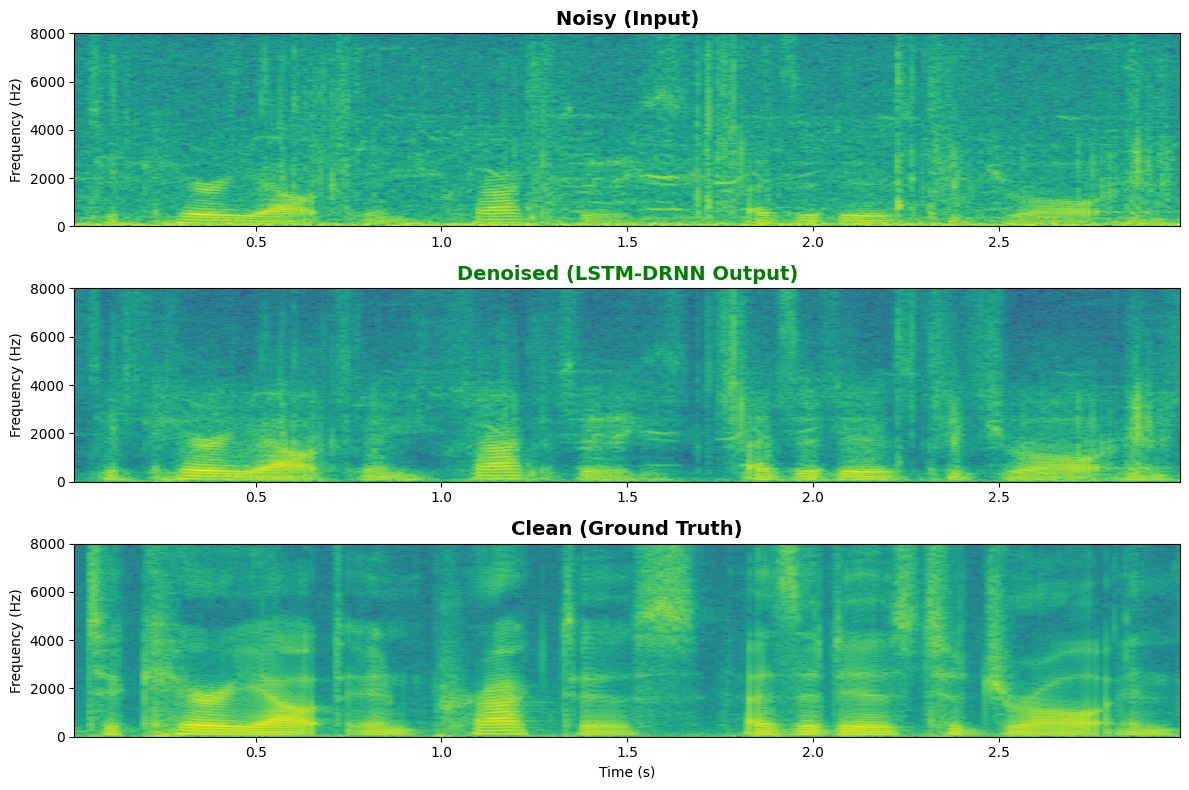

In [15]:
# Visualize spectrograms to see the denoising
import matplotlib.pyplot as plt

def plot_spectrograms(noisy_np, denoised_np, clean_np):
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    
    # Compute spectrograms
    from matplotlib import mlab
    
    # Noisy
    Pxx_noisy, freqs, bins, im = axes[0].specgram(noisy_np, NFFT=512, Fs=TARGET_SAMPLE_RATE, 
                                                    noverlap=384, cmap='viridis')
    axes[0].set_title('Noisy (Input)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Frequency (Hz)')
    
    # Denoised
    Pxx_denoised, freqs, bins, im = axes[1].specgram(denoised_np, NFFT=512, Fs=TARGET_SAMPLE_RATE,
                                                       noverlap=384, cmap='viridis')
    axes[1].set_title('Denoised (LSTM-DRNN Output)', fontsize=14, fontweight='bold', color='green')
    axes[1].set_ylabel('Frequency (Hz)')
    
    # Clean
    Pxx_clean, freqs, bins, im = axes[2].specgram(clean_np, NFFT=512, Fs=TARGET_SAMPLE_RATE,
                                                    noverlap=384, cmap='viridis')
    axes[2].set_title('Clean (Ground Truth)', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Frequency (Hz)')
    axes[2].set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.savefig('spectrogram_comparison.png', dpi=150, bbox_inches='tight')
    print("Saved spectrogram comparison to 'spectrogram_comparison.png'")
    print("Look for: Denoised should have cleaner formant structure (horizontal bands) than Noisy")
    plt.show()

# Load the saved WAV files to ensure we're comparing exact same audio
import soundfile as sf
noisy_wav, _ = sf.read("lstm_very_noisy_noisy.wav")
denoised_wav, _ = sf.read("lstm_very_noisy_denoised.wav")
clean_wav, _ = sf.read("lstm_very_noisy_clean.wav")

print("\n" + "="*80)
print("VISUAL COMPARISON: Spectrograms")
print("="*80)

plot_spectrograms(noisy_wav, denoised_wav, clean_wav)